# k-vecinos más cercanos versión 2

In [1]:
import os
import path
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, classification_report, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Path = "/home/michell21/Datasets/" #Puede cambiar de acuerdo al usuario

Instalar las siguientes librerías para leer el archivo

- conda install xlrd
- conda install openpyxl

In [3]:
read = pd.read_excel(Path+'Pozos_Michoacan.xlsx')

In [4]:
pozos = pd.DataFrame(pd.read_excel(Path+'Pozos_Michoacan.xlsx'))

In [5]:
pozos.head()

,#,Título,Latitud,Longitud,Estado,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
0,1,837156,"19°58'36.0006""","-101°16'41.0007""",MICHOACÁN DE OCAMPO,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0,AGRICOLA
1,2,836988,"19°59'22.0004""","-101°16'30.0003""",MICHOACÁN DE OCAMPO,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0,AGRICOLA
2,3,836992,"20°02'22.0006""","-101°09'00.0005""",MICHOACÁN DE OCAMPO,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0,AGRICOLA
3,4,836822,"20°01'50.0005""","-101°09'38.0006""",MICHOACÁN DE OCAMPO,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0,AGRICOLA
4,5,835739,"19°49'11.0005""","-101°08'37.0006""",MICHOACÁN DE OCAMPO,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0,SERVICIOS


In [28]:
pozos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   #                   1363 non-null   int64  
 1   Título              1363 non-null   object 
 2   Latitud             1363 non-null   object 
 3   Longitud            1363 non-null   object 
 4   Estado              1363 non-null   object 
 5   Municipio           1363 non-null   object 
 6   RegiónHidrológica   1363 non-null   object 
 7   Cuenca              1363 non-null   int64  
 8   AcuíferoHomologado  1363 non-null   object 
 9   Volumen (m3/año)    1363 non-null   float64
 10  Uso                 1363 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 117.3+ KB


In [5]:
pozos.describe()

,#,Cuenca,Volumen (m3/año)
count,1363.00000,1363.000000,1.363000e+03
mean,682.00000,28.546588,1.558366e+05
std,393.60852,67.485278,3.884465e+05
min,1.00000,0.000000,0.000000e+00
25%,341.50000,0.000000,1.500000e+04
50%,682.00000,0.000000,4.668000e+04
75%,1022.50000,0.000000,1.621800e+05
max,1363.00000,188.000000,1.103760e+07


Como no hay registros vacios, se procede a trabajar con los datos. Lo primero será borrar la columna # 

# Visualización de Datos

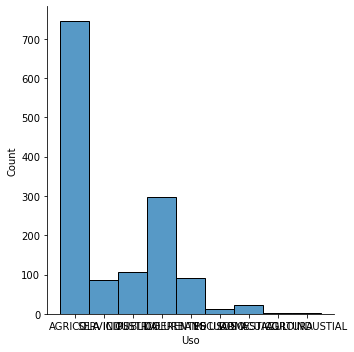

In [6]:
sns.displot(pozos['Uso'], palette="rocket")

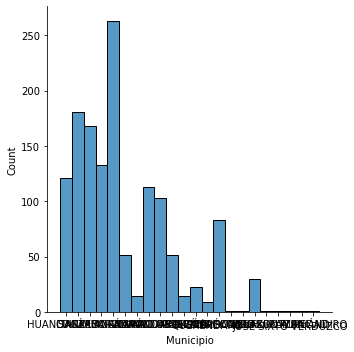

In [7]:
sns.displot(pozos['Municipio'], palette="rocket")

In [5]:
pozos.drop(['#', 'Estado', "Título"], axis = 1, inplace = True) #Eliminamos estos dos ya que no aportan información

In [6]:
def grad2float(datos, id1,id2):
    characters = '°\'"'
    lista = []
    for i in datos:
        i = ''.join( x for x in i if x not in characters)
        if i[0] == '-':
            a = -1*(3600*float(i[1:id1]) + 60*float(i[id1:id2]) + float(i[id2:])) #Para longitud
        else:
            a = 3600*float(i[:id1]) + 60*float(i[id1:id2]) + float(i[id2:])
        #a = 3600*float(i[:4]) + 60*float(i[4:6]) + float(i[6:]) #Para latitud
        lista.append(float(a))
    return lista

In [7]:
pozos['Latitud'] = grad2float(pozos['Latitud'], 2, 4)
pozos['Longitud'] = grad2float(pozos['Longitud'], 4, 6)

In [8]:
pozos['Uso'].value_counts()  #No unir a Diferentes usos

AGRICOLA           745
PUBLICO URBANO     296
INDUSTRIAL         107
DIFERENTES USOS     91
SERVICIOS           87
DOMESTICO           23
PECUARIO            11
ACUACULTURA          2
AGROINDUSTIAL        1
Name: Uso, dtype: int64

In [84]:
pozos['AcuíferoHomologado'].value_counts()  #Eliminar

1602 - MORELIA-QUERENDARO       1335
1610 - CIUDAD HIDALGO-TUXPAN      28
Name: AcuíferoHomologado, dtype: int64

In [9]:
pozos[pozos['Uso'] == 'ACUACULTURA']

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
280,71665.0,-363020.0,ZINAPÉCUARO,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,30000.0,ACUACULTURA
1302,71663.0,-364157.0,CUITZEO,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,15000.0,ACUACULTURA


In [10]:
pozos[pozos['Uso'] == 'AGROINDUSTIAL']

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
941,72255.0,-364034.0,SANTA ANA MAYA,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,40000.0,AGROINDUSTIAL


In [8]:
#Reemplazar 1602  - MORELIA-QUERENDARO con 1602 - MORELIA-QUERENDARO
pozos['AcuíferoHomologado'].replace('1602  - MORELIA-QUERENDARO', '1602 - MORELIA-QUERENDARO', inplace = True)

In [9]:
pozos.describe()

,Latitud,Longitud,Cuenca,Volumen (m3/año)
count,1363.000000,1363.000000,1363.000000,1.363000e+03
mean,71490.946855,-364096.132121,28.546588,1.558366e+05
std,645.397221,721.149748,67.485278,3.884465e+05
min,68005.000000,-371361.000000,0.000000,0.000000e+00
25%,71118.004800,-364411.500000,0.000000,1.500000e+04
50%,71468.000000,-364145.000000,0.000000,4.668000e+04
75%,71938.250000,-363778.000000,0.000000,1.621800e+05
max,79260.000000,-362170.000000,188.000000,1.103760e+07


In [9]:
pozos.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
0,71916.0006,-364601.0007,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0,AGRICOLA
1,71962.0004,-364590.0003,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0,AGRICOLA
2,72142.0006,-364140.0005,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0,AGRICOLA
3,72110.0005,-364178.0006,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0,AGRICOLA
4,71351.0005,-364117.0006,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0,SERVICIOS


# Dividir los datos en $X$ y $y$

In [10]:
X = pozos.iloc[:,:-1]
y = pozos['Uso']
#y = pozos[['Uso', 'Uso Ponderado']]

In [11]:
X.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año)
0,71916.0006,-364601.0007,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0
1,71962.0004,-364590.0003,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0
2,72142.0006,-364140.0005,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0
3,72110.0005,-364178.0006,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0
4,71351.0005,-364117.0006,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0


In [12]:
y.head() 

0     AGRICOLA
1     AGRICOLA
2     AGRICOLA
3     AGRICOLA
4    SERVICIOS
Name: Uso, dtype: object

## Codificar los datos categoricos y Escalar los datos numericos en X

In [11]:
def codificar(data):
    cat = []
    num = []
    for i in data.columns:
        if data[i].dtypes == 'object':
            cat.append(i)
        elif data[i].dtypes == 'float64' or 'int64':
            num.append(i)
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(data[num])
    data[num] = scaled_values
    code = LabelEncoder()
    data[cat] = data[cat].apply(code.fit_transform)
    print('num', num)
    print('cat',cat)
    return data

In [12]:
x_cod = X.copy()
X_cod = codificar(X)

num ['Latitud', 'Longitud', 'Cuenca', 'Volumen (m3/año)']
cat ['Municipio', 'RegiónHidrológica', 'AcuíferoHomologado']


In [15]:
X_cod.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año)
0,0.347490,0.735502,7,1,1.0,0,0.002066
1,0.351577,0.736699,7,1,1.0,0,0.000815
2,0.367570,0.785660,5,1,1.0,0,0.001814
3,0.364727,0.781525,5,1,1.0,0,0.000544
4,0.297290,0.788162,18,1,1.0,0,0.002718


# Dividir los datos en Train y Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_cod, y, test_size = 0.3, shuffle=True)

# Construir modelo

In [14]:
#n_neighbors = 3

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [15]:
# Predicción
def prediccion(model, X, y):
    pred = model.predict(X)
    y_pred = pd.Series(pred, index=y.index)
    print('Precisión = ', precision_score(y, y_pred, average='micro'))
    print(classification_report(y, pred))
    plot_confusion_matrix(model, X, y)
    return y_pred

Precisión =  0.6356968215158925
                 precision    recall  f1-score   support

    ACUACULTURA       0.00      0.00      0.00         0
       AGRICOLA       0.79      0.79      0.79       224
  AGROINDUSTIAL       0.00      0.00      0.00         1
DIFERENTES USOS       0.09      0.08      0.09        25
      DOMESTICO       0.00      0.00      0.00         4
     INDUSTRIAL       0.81      0.77      0.79        44
       PECUARIO       0.50      0.25      0.33         4
 PUBLICO URBANO       0.46      0.43      0.45        81
      SERVICIOS       0.30      0.38      0.34        26

       accuracy                           0.64       409
      macro avg       0.33      0.30      0.31       409
   weighted avg       0.64      0.64      0.64       409



/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

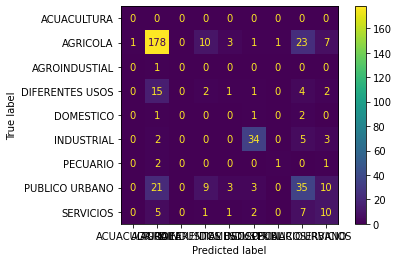

In [16]:
y_pred = prediccion(knn, X_test, y_test)

## Saber cuales fueron las etiquetas que sí acertó

In [17]:
def match(y_t, y_p):
    matched = {}
    aux = 0
    for i, j in zip(y_t, y_p):
        if i == j:
            matched[y_t.index[aux]]= i
        aux+=1
    return matched
aux = match(y_test, y_pred)

In [18]:
len(aux)

260

## Obtener el volumen total

In [19]:
volumen_total = sum(pozos['Volumen (m3/año)'].values)
print(volumen_total)

212405314.46999994


In [20]:
def volumen(data, indices, vol):
    vol_pond = {}
    for i in list(indices.keys()):
        v_pond = (data.iloc[i][6])/vol
        vol_pond[i] = indices[i], v_pond
    vol_pond = pd.DataFrame([[key, vol_pond[key][0], vol_pond[key][1]] for key in vol_pond.keys()], columns=['ID', 'Uso', 'Volumen Ponderado'])
    return vol_pond
volumen_pon = volumen(pozos, aux, volumen_total)

In [21]:
volumen_pon.groupby('Uso').sum()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,126580,0.120718
DIFERENTES USOS,616,0.000169
INDUSTRIAL,20878,0.075899
PECUARIO,1008,0.000030
PUBLICO URBANO,22527,0.029778
SERVICIOS,3976,0.002158


## Obtener el volumen ponderado por etiquetas

In [22]:
v = pozos.groupby('Uso').sum()
v = v['Volumen (m3/año)']
v

Uso
ACUACULTURA           45000.00
AGRICOLA           91725771.79
AGROINDUSTIAL         40000.00
DIFERENTES USOS     5866832.32
DOMESTICO           1354190.77
INDUSTRIAL         60461754.00
PECUARIO             195005.00
PUBLICO URBANO     47014568.69
SERVICIOS           5702191.90
Name: Volumen (m3/año), dtype: float64

In [23]:
def vol_lab(data, indices, vol):
    vol_pond = {}
    for i in list(indices.keys()):
        vl = vol[indices[i]] #volumen total por etiqueta
        v_pond = (data.iloc[i])/vl #Volumen ponderado por etiqueta
        vol_pond[i] = indices[i], v_pond
    vol_pond = pd.DataFrame([[key, vol_pond[key][0], vol_pond[key][1]] for key in vol_pond.keys()], columns=['ID', 'Uso', 'Volumen Ponderado'])
    return vol_pond
vol_label = vol_lab(pozos['Volumen (m3/año)'], aux, v)

In [24]:
vol_label.groupby('Uso').sum()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,126580,0.279542
DIFERENTES USOS,616,0.006126
INDUSTRIAL,20878,0.266637
PECUARIO,1008,0.032384
PUBLICO URBANO,22527,0.134535
SERVICIOS,3976,0.080380


Como se puede ver en esta segunda tabla, hay mejores resultados si ponderamos por etiqueta

# Hacer el mismo procedimiento con los siguientes modelos

## Hacer un nuevo modelo con cross validation

In [25]:
knn_cv = KNeighborsClassifier()
cv_scores = cross_val_score(knn_cv, X_cod, y, cv=10)
print(cv_scores)
print("Score promedio", np.mean(cv_scores))

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[0.70072993 0.5620438  0.60583942 0.64705882 0.71323529 0.64705882
 0.67647059 0.66911765 0.63970588 0.52205882]
Score promedio 0.6383319021039073


El mejor score es con k = 5

## Usar GridSearchCV para ver el número óptimo de K

In [26]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
#fit model to data
knn_gscv.fit(X_train, y_train)

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [27]:
knn_gscv.best_params_

{'n_neighbors': 24}

In [28]:
knn_gscv.best_score_

0.6729714912280701

Precisión =  0.6772616136919315
                 precision    recall  f1-score   support

       AGRICOLA       0.74      0.90      0.81       224
  AGROINDUSTIAL       0.00      0.00      0.00         1
DIFERENTES USOS       0.00      0.00      0.00        25
      DOMESTICO       0.00      0.00      0.00         4
     INDUSTRIAL       0.82      0.70      0.76        44
       PECUARIO       0.00      0.00      0.00         4
 PUBLICO URBANO       0.53      0.51      0.52        81
      SERVICIOS       0.19      0.15      0.17        26

       accuracy                           0.68       409
      macro avg       0.28      0.28      0.28       409
   weighted avg       0.61      0.68      0.64       409



/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

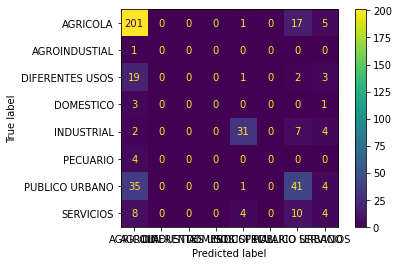

In [29]:
knn_grid = knn_gscv.best_estimator_
y_pred_grid = prediccion(knn_grid, X_test, y_test)

In [30]:
#Obtener las etiquetas acertadas
aux1 = match(y_test, y_pred_grid)
len(aux1) #por ahora hay +10 etiquetas que en el caso anterior

277

In [32]:
#Sacar el volumen ponderado
volumen_pon1 = volumen(pozos, aux1, volumen_total)
volumen_pon1.groupby('Uso').mean()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,697.009950,0.000603
INDUSTRIAL,538.322581,0.002325
PUBLICO URBANO,630.804878,0.000782
SERVICIOS,481.250000,0.000210


In [33]:
#Sacar el volumen ponderado por etiquetas
vol_label1 = vol_lab(pozos['Volumen (m3/año)'], aux1, v)
vol_label1.groupby('Uso').mean()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,697.009950,0.001397
INDUSTRIAL,538.322581,0.008166
PUBLICO URBANO,630.804878,0.003532
SERVICIOS,481.250000,0.007819


# Encontrar el valor de k

([<matplotlib.axis.YTick at 0x7fd7504ad430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

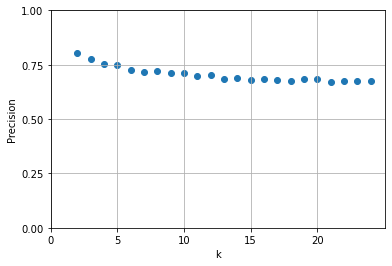

In [34]:
#No usar test. Se sobreajusta

k_range = range(2, 25)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    pred1=knn.predict(X_train)
    scores.append(precision_score(y_train, pred1, average='micro'))
#plt.figure()
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('Precision')
plt.grid()
plt.xticks([0,5,10,15,20])
plt.yticks([0, 0.25, 0.5, 0.75, 1])

A patir de k = 15, la precisión empieza a ocilar 

In [35]:
knn_k = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_k.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15, weights='distance')

Precisión =  0.6723716381418093
                 precision    recall  f1-score   support

       AGRICOLA       0.76      0.85      0.81       224
  AGROINDUSTIAL       0.00      0.00      0.00         1
DIFERENTES USOS       0.08      0.04      0.05        25
      DOMESTICO       0.00      0.00      0.00         4
     INDUSTRIAL       0.84      0.82      0.83        44
       PECUARIO       0.00      0.00      0.00         4
 PUBLICO URBANO       0.50      0.48      0.49        81
      SERVICIOS       0.33      0.31      0.32        26

       accuracy                           0.67       409
      macro avg       0.31      0.31      0.31       409
   weighted avg       0.63      0.67      0.65       409



/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

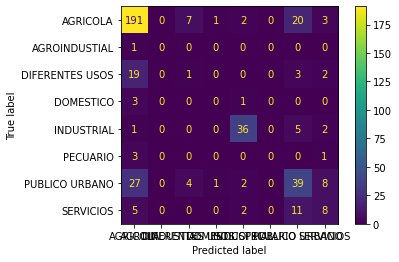

In [36]:
y_pred_k = prediccion(knn_k, X_test, y_test)

In [37]:
aux2 = match(y_test, y_pred_k)
len(aux2) #por ahora hay -1 etiquetas que en el caso anterior

275

In [38]:
#Sacar el volumen ponderado
volumen_pon2 = volumen(pozos, aux2, volumen_total)
volumen_pon2.groupby('Uso').mean()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,709.455497,0.000638
DIFERENTES USOS,417.000000,0.000075
INDUSTRIAL,621.777778,0.002115
PUBLICO URBANO,614.615385,0.000766
SERVICIOS,345.000000,0.000161


In [39]:
#Sacar el volumen ponderado por etiquetas
vol_label2 = vol_lab(pozos['Volumen (m3/año)'], aux2, v)
vol_label2.groupby('Uso').mean()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,709.455497,0.001478
DIFERENTES USOS,417.000000,0.002717
INDUSTRIAL,621.777778,0.007430
PUBLICO URBANO,614.615385,0.003459
SERVICIOS,345.000000,0.005992


## Graficar los datos

In [25]:
pozos['Uso'].unique()

array(['AGRICOLA', 'SERVICIOS', 'INDUSTRIAL', 'PUBLICO URBANO',
       'DIFERENTES USOS', 'PECUARIO', 'DOMESTICO'], dtype=object)

In [47]:
#y_test
label_or = y_test.map({'AGRICOLA': 0, 'SERVICIOS': 1, 'INDUSTRIAL': 2, 'PUBLICO URBANO': 3,
                   'DIFERENTES USOS': 4, 'PECUARIO':5, 'DOMESTICO': 6, 'ACUACULTURA': 7, 'AGROINDUSTIAL': 8},na_action=None)

In [53]:
#y_pred
label_pred = y_pred.map({'AGRICOLA': 0, 'SERVICIOS': 1, 'INDUSTRIAL': 2, 'PUBLICO URBANO': 3,
                   'DIFERENTES USOS': 4, 'PECUARIO':5, 'DOMESTICO': 6, 'ACUACULTURA': 7, 'AGROINDUSTIAL': 8},na_action=None)

In [57]:
#y_pred_grif
label_grid = y_pred_grid.map({'AGRICOLA': 0, 'SERVICIOS': 1, 'INDUSTRIAL': 2, 'PUBLICO URBANO': 3,
                   'DIFERENTES USOS': 4, 'PECUARIO':5, 'DOMESTICO': 6, 'ACUACULTURA': 7, 'AGROINDUSTIAL': 8},na_action=None)

In [55]:
#y_pred_k
label_k = y_pred_k.map({'AGRICOLA': 0, 'SERVICIOS': 1, 'INDUSTRIAL': 2, 'PUBLICO URBANO': 3,
                   'DIFERENTES USOS': 4, 'PECUARIO':5, 'DOMESTICO': 6, 'ACUACULTURA': 7, 'AGROINDUSTIAL': 8},na_action=None)

In [51]:
def grafica(data):
    for i in range(10):
        plt.scatter(x=data[data==i].index, y=data[data==i], cmap='Sequential')
    return plt.show()

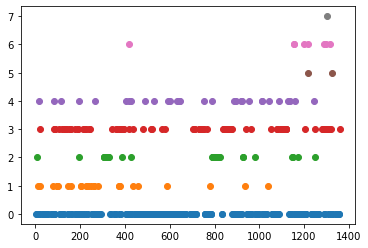

In [52]:
grafica(label_or) #original

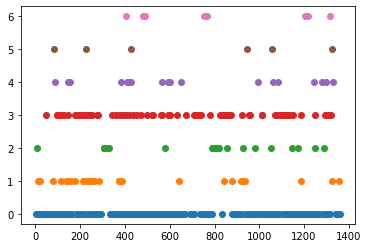

In [56]:
grafica(label_pred) #Primera prediccion k=3

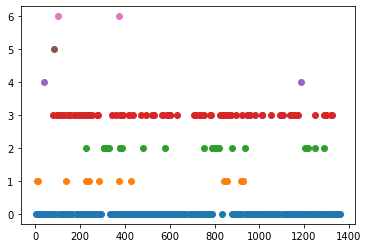

In [58]:
grafica(label_grid)

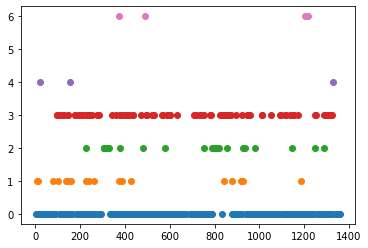

In [59]:
grafica(label_k)